# **AMP Design using RNN / AR**


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os

In [ ]:
"""
Import AMP dataset from https://github.com/alexarnimueller/LSTM_peptides.
Peptides are of various lengths so max/min length is recorded.
"""

text = open('training_sequences_noC.csv')
sequences=[]
for line in text:
   sequences.append(line.strip())

maxLength = max(set(len(i) for i in sequences))
minLength = min(set(len(i) for i in sequences))

In [ ]:
"""
The dictionary code2idx translates residues to numbers.
The list idx2code translates the reverse.
With these functions, peptides are translated into matrices.
"""

vocab = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', ' ']
code2idx = {u:i for i,u in enumerate(vocab)}
idx2code = np.array(vocab)

intseq=[]
for i in sequences:
   a=[]
   for c in i:
      a.append(code2idx[c])
   for j in range(maxLength-len(i)):
      a.append(code2idx[' '])
   intseq.append(a)
intseq = np.array(intseq)

print(intseq.shape)

(1554, 48)


In [ ]:
"""
Preparing training dataset and target values for the RNN.
Target values are simply the training data shifted one slot to the right.
"""

trainData=intseq[:,:-1]
targetData=intseq[:,1:]
print(trainData.shape)
print(targetData.shape)

(1554, 47)
(1554, 47)


## **RNN Design**

In [ ]:
"""
Defining various training parameters.
Batch size is set to 64, and since RNN cannot train on an incomplete batch, 
the last 18 instances are dropped out from training.
"""

vocab_size = len(vocab)

embedding_dim = 16

rnn_units = 256

BATCH_SIZE = 64
trainData=trainData[0:((len(trainData)//BATCH_SIZE)*BATCH_SIZE),]
targetData=targetData[0:((len(targetData)//BATCH_SIZE)*BATCH_SIZE),]
print(trainData.shape)
print(targetData.shape)

(1536, 47)
(1536, 47)


In [ ]:
"""
Function generating an RNN model.
"""

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
"""
RNN model is built.
"""

model = build_model(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (64, None, 16)            352       
_________________________________________________________________
gru_2 (GRU)                  (64, None, 256)           210432    
_________________________________________________________________
gru_3 (GRU)                  (64, None, 256)           394752    
_________________________________________________________________
dense_3 (Dense)              (64, None, 22)            5654      
Total params: 611,190
Trainable params: 611,190
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
Compiling the model and preparing for training.
"""

def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
model.compile(optimizer='adam', loss=loss)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
"""
Training the model.
1536/64 = 24 batches exist in total, and 3(12.5%) of them are used for validation.
EarlyStopping prevents overfitting.
"""
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')

history = model.fit(x=trainData, y=targetData, batch_size=64, epochs=200, validation_split = 0.125, callbacks=[checkpoint_callback, earlyStopping])

Epoch 1/200
21/21 [==============================] - 7s 347ms/step - loss: 0.5032 - val_loss: 0.5984
Epoch 2/200
21/21 [==============================] - 7s 346ms/step - loss: 0.4886 - val_loss: 0.5908
Epoch 3/200
21/21 [==============================] - 7s 350ms/step - loss: 0.4770 - val_loss: 0.5894
Epoch 4/200
21/21 [==============================] - 7s 347ms/step - loss: 0.4697 - val_loss: 0.5869
Epoch 5/200
21/21 [==============================] - 7s 347ms/step - loss: 0.4614 - val_loss: 0.5835
Epoch 6/200
21/21 [==============================] - 8s 361ms/step - loss: 0.4494 - val_loss: 0.5699
Epoch 7/200
21/21 [==============================] - 7s 343ms/step - loss: 0.4379 - val_loss: 0.5728
Epoch 8/200
21/21 [==============================] - 7s 342ms/step - loss: 0.4264 - val_loss: 0.5634
Epoch 9/200
21/21 [==============================] - 7s 341ms/step - loss: 0.4143 - val_loss: 0.5624
Epoch 10/200
21/21 [==============================] - 7s 342ms/step - loss: 0.4057 - val_lo

In [ ]:
"""
Based on the weights of the trained model, build a generating model that outputs a peptide residue.
"""

print(tf.train.latest_checkpoint(checkpoint_dir))

Genmodel = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
Genmodel.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
Genmodel.build(tf.TensorShape([1, None]))

Genmodel.summary()

./training_checkpoints/ckpt_36
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 16)             352       
_________________________________________________________________
gru_4 (GRU)                  (1, None, 256)            210432    
_________________________________________________________________
gru_5 (GRU)                  (1, None, 256)            394752    
_________________________________________________________________
dense_4 (Dense)              (1, None, 22)             5654      
Total params: 611,190
Trainable params: 611,190
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
generate_prot function produces a peptide sequence based on the generator model.
The revursive function produces sequences of length between 7 and 49 residues.

Temperature value controls degree of randomness of the sequence residues,

"""

def generate_prot(model, start_string, Temperature):
  
  num_generate = (maxLength+1)
  text_generated = []

  input_eval = [code2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  temperature = Temperature

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)

      # categorical distribution을 사용하여 return할 알파벳을 결정합니다.
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      if idx2code[predicted_id] == ' ':
          break

      text_generated.append(idx2code[predicted_id])

  if len(text_generated) < (maxLength+1):
      if len(text_generated) > (minLength-1):
          return (''.join(text_generated))
      else:
          return generate_prot(model, start_string, Temperature)
  else:
      return generate_prot(model, start_string, Temperature)
      

In [ ]:
"""
residue 'B' is used to indicate start of a new peptide sequence.
"""

print(generate_prot(Genmodel, start_string="B", Temperature=1))

GMLKGVAKVLAFGVAN


## **AuroRegression Design**

In [ ]:
"""
Function building an autoregression model.
Conv1D function with padding='causal' is used.
"""


def build_model2 (vocab_size, embedding_dim):
  model = tf.keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim),
    layers.Conv1D(filters=128, kernel_size=48, strides=1, padding='causal'),
    layers.Conv1D(filters=32, kernel_size=48, strides=1, padding='causal'),
    layers.Dense(vocab_size)
  ])
  return model

model2 = build_model2(vocab_size, embedding_dim)
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          352       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          196640    
_________________________________________________________________
dense_5 (Dense)              (None, None, 22)          726       
Total params: 296,150
Trainable params: 296,150
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
Training the model using the same training and target data as RNN.
"""

def loss2(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
model2.compile(optimizer='adam', loss=loss2)

earlyStopping2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')

history2 = model2.fit(x=trainData, y=targetData, epochs=50, validation_split = 0.125, callbacks=[earlyStopping2])

Epoch 1/50
42/42 [==============================] - 5s 112ms/step - loss: 1.7033 - val_loss: 1.3906
Epoch 2/50
42/42 [==============================] - 5s 115ms/step - loss: 1.3049 - val_loss: 1.2378
Epoch 3/50
42/42 [==============================] - 5s 110ms/step - loss: 1.1989 - val_loss: 1.1492
Epoch 4/50
42/42 [==============================] - 5s 111ms/step - loss: 1.1233 - val_loss: 1.0627
Epoch 5/50
42/42 [==============================] - 5s 111ms/step - loss: 1.0528 - val_loss: 1.0008
Epoch 6/50
42/42 [==============================] - 5s 110ms/step - loss: 1.0054 - val_loss: 0.9580
Epoch 7/50
42/42 [==============================] - 5s 111ms/step - loss: 0.9702 - val_loss: 0.9268
Epoch 8/50
42/42 [==============================] - 5s 110ms/step - loss: 0.9418 - val_loss: 0.9048
Epoch 9/50
42/42 [==============================] - 5s 110ms/step - loss: 0.9173 - val_loss: 0.8843
Epoch 10/50
42/42 [==============================] - 5s 110ms/step - loss: 0.8958 - val_loss: 0.8695

In [ ]:
"""
Utilizing generate_prot function to generate peptide sequences from AR model.
"""

print(generate_prot(model2, start_string="B", Temperature=1))

KLFSAPFLVLILL


## **Data comparison**
comparison to the paper "Recurrent Neural Network Model for Constructive Peptide Design"

In [ ]:
"""
Calculating ratio of valid sequences (those that are not included in training data and don't include 'B' residue).
50 generations from 4 temperatures from both RNN and AR models are compared.
"""

def IsValid(seq):
   for i in seq:
      if i=='B':
          return False
   if seq in sequences:
      return False
   return True 

T=[0.75, 1, 1.25, 1.5]
RNNs = []
ARs = []
for i in range(len(T)):
    a=[]
    b=[]
    for j in range(50):
        a.append(generate_prot(Genmodel, start_string='B', Temperature = T[i]))
        b.append(generate_prot(model2, start_string='B', Temperature = T[i]))
    RNNs.append(a)
    ARs.append(b)



In [ ]:
RNNCount=[]
ARCount=[]
for i in range(len(T)):
    c=0
    d=0
    for j in range(50):
        if IsValid(RNNs[i][j])==1:
           c+=1
        if IsValid(ARs[i][j])==1:
           d+=1
    RNNCount.append((c/50))
    ARCount.append((d/50))
print("  Temperature         0.75   1   1.25  1.5")
print("Ratio for RNN model", RNNCount)
print("Ratio for AR  model", ARCount)

  Temperature         0.75   1   1.25  1.5
Ratio for RNN model [0.88, 0.94, 0.88, 0.82]
Ratio for AR  model [1.0, 0.98, 0.96, 0.96]


In [ ]:
"""
From the results, we can estimate temperature of 1 to be an adequate value.
200 valid sequences are generated from both RNN and AR model and p(AMP) probability
is calculated at http://www.camp3.bicnirrh.res.in/predict/.
"""

R=[]
A=[]
for i in range(250):
    e = generate_prot(Genmodel, start_string='B', Temperature = 1)
    if IsValid(e)==1:
        R.append(e)
    e = generate_prot(model2, start_string='B', Temperature = 1)
    if IsValid(e)==1:
        A.append(e)
R=R[:200]
A=A[:200]


In [ ]:
"""
Preparing fasta file for uploading.
"""

f = open('RNNFASTA.fasta', 'w')
for i in range(200):
    f.write(">seq%d\n" % i)
    f.write(R[i])
    f.write("\n")
f.close()

g = open('ARFASTA.fasta', 'w')
for i in range(200):
    g.write(">seq%d\n" % i)
    g.write(A[i])
    g.write("\n")
g.close()

results for RNN model


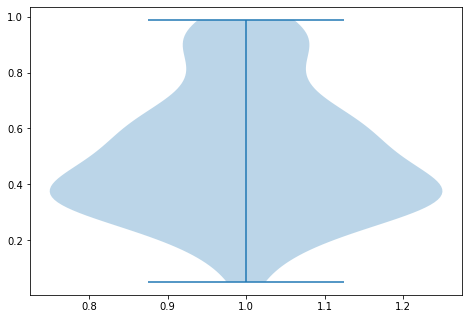

In [ ]:
"""
Load p(AMP) values (RNNResult.csv, ARResult.csv).
violin plots are drawn for visualization of the results.
"""

f=open('RNNResult.csv','r')
RNNResults=[]
for i in f:
    RNNResults.append(float(i.strip()))
f.close()
import matplotlib.pyplot as plt


## combine these different collections into a list
data_to_plot = RNNResults

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot)
print("results for RNN model")
plt.show()

results for AR model


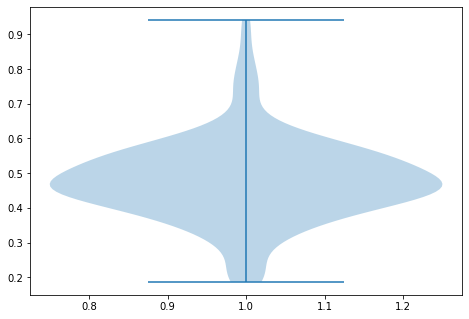

In [ ]:
g=open('ARResult.csv','r')
ARResults=[]
for i in g:
    ARResults.append(float(i.strip()))
g.close()
import matplotlib.pyplot as plt


## combine these different collections into a list
data_to_plot = ARResults

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot)
print("results for AR model")
plt.show()